In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

def show_stock_forecast(stock_name:str,col:int=0,offset:int=0,start_date:int=300)->None:
    pickle_path = f'./save/stock_new_random/{stock_name}.pk' # set the folder name

    path = pickle_path
    with open(path, 'rb') as f:
        samples,all_target,all_evalpoint,all_observed,_,_,_ = pickle.load( f)

    all_target_np = all_target.cpu().numpy()
    all_evalpoint_np = all_evalpoint.cpu().numpy()
    all_observed_np = all_observed.cpu().numpy()
    all_given_np = all_observed_np - all_evalpoint_np

    K = samples.shape[-1] #feature
    L = samples.shape[-2] #time length


    qlist =[0.05,0.25,0.5,0.75,0.95]
    quantiles_imp= []
    for q in qlist:
        quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)
        
    plt.rcParams["font.size"] = 16
    n_row=5; n_col=4
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col,figsize=(n_col*5, n_col*5))
    fig.delaxes(axes[-1][-1])

    for _index in range(0,n_row*n_col):
        index=_index+offset
        df = pd.DataFrame({"x":np.arange(start_date,L), "val":all_target_np[index,start_date:,col], "y":all_evalpoint_np[index,start_date:,col]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(start_date,L), "val":all_target_np[index,start_date:,col], "y":all_given_np[index,start_date:,col]})
        df2 = df2[df2.y != 0]
        row = _index // 4
        col = _index % 4
        axes[row][col].plot(range(start_date,L), quantiles_imp[2][index,start_date:,col], color = 'g',linestyle='solid',label='CSDI')
        axes[row][col].fill_between(range(start_date,L), quantiles_imp[0][index,start_date:,col],quantiles_imp[4][index,start_date:,col],
                        color='g', alpha=0.3)
        axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')


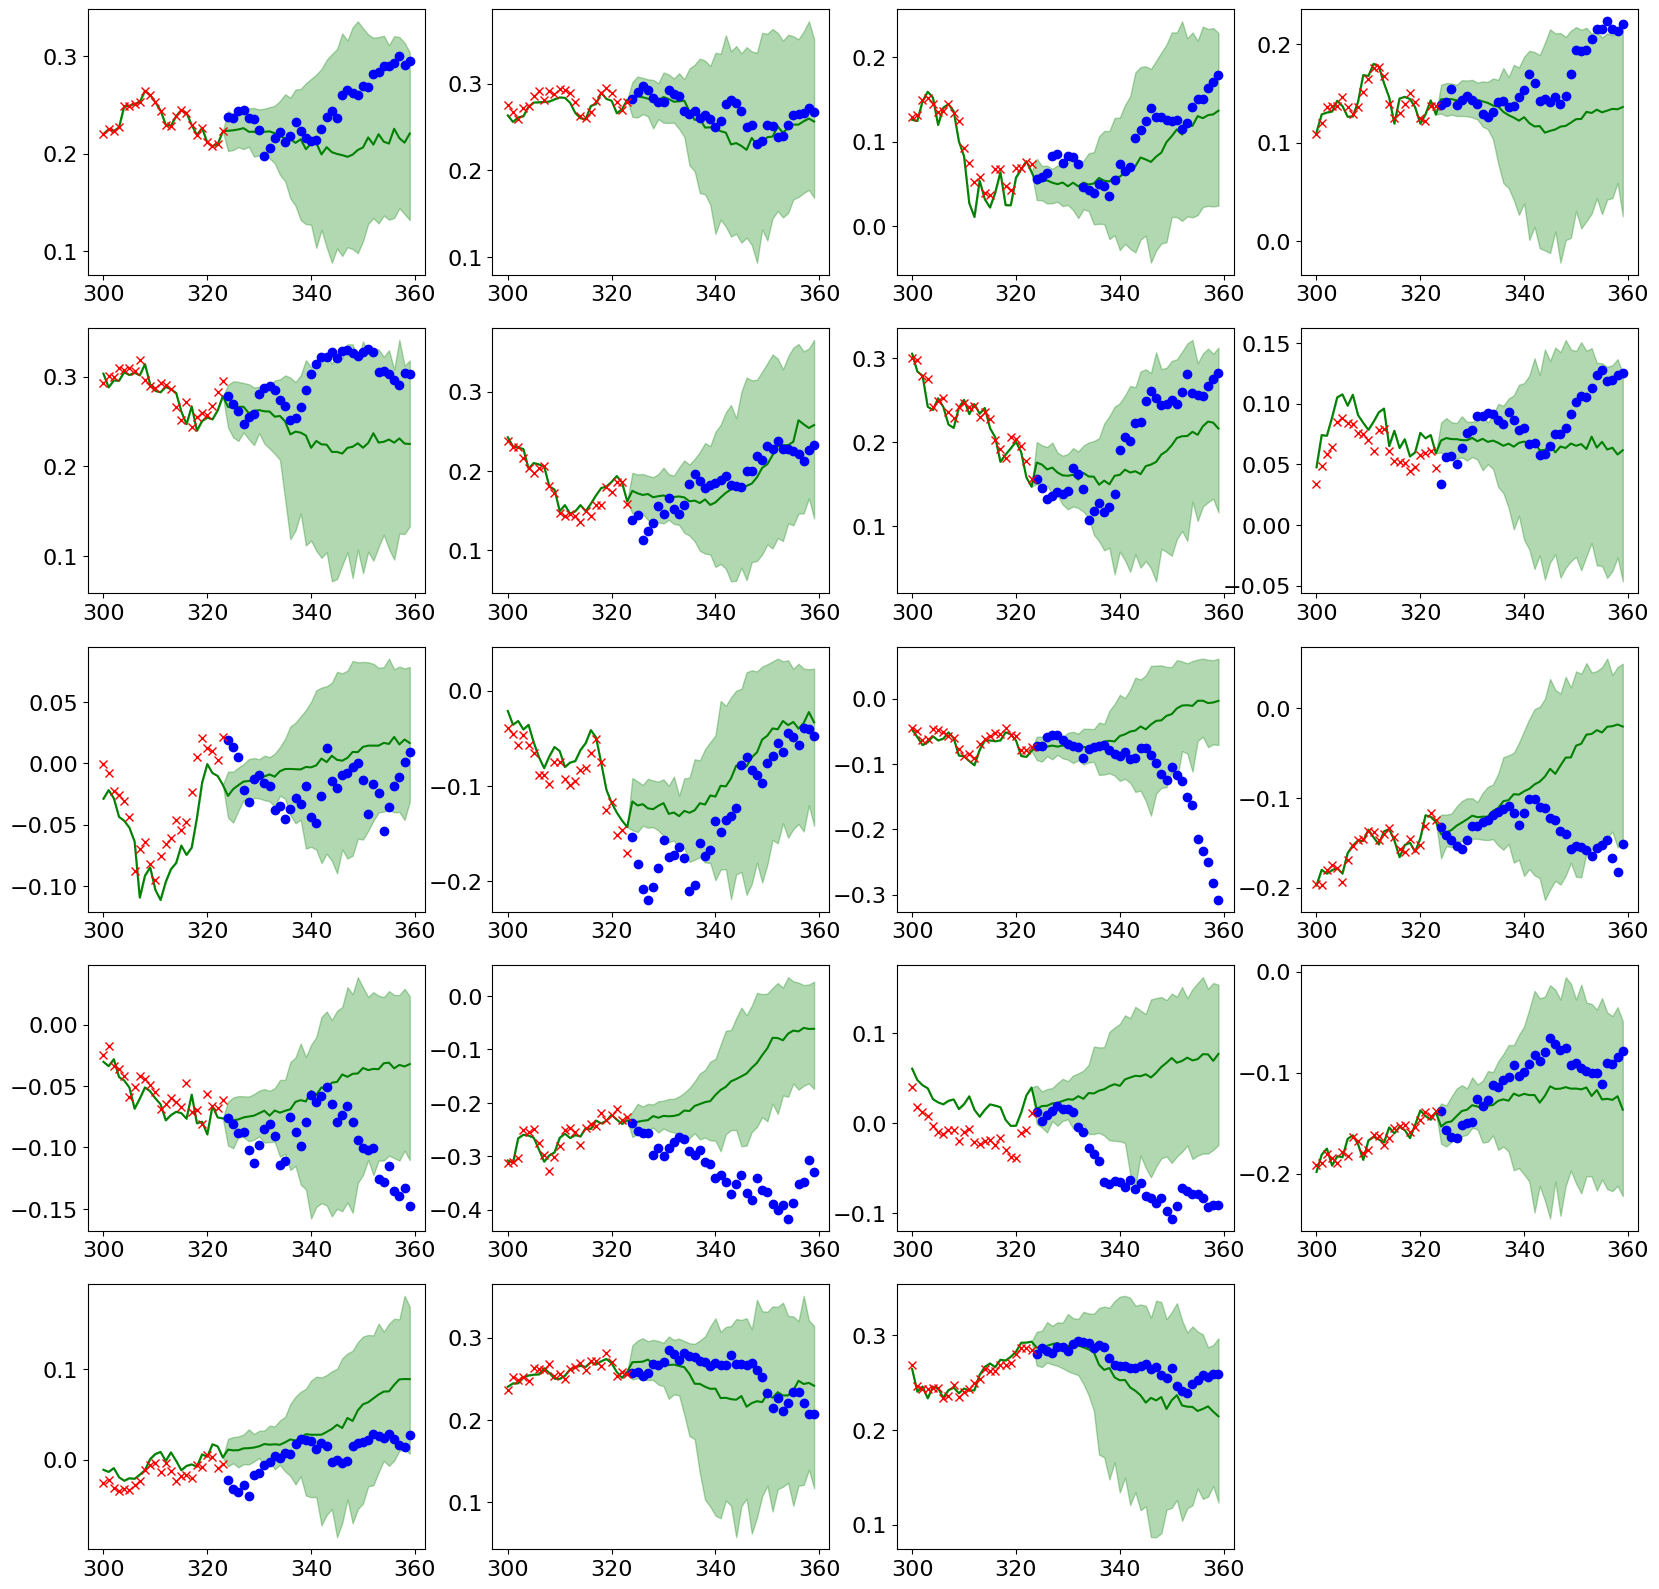

In [9]:
show_stock_forecast("random",0,20)

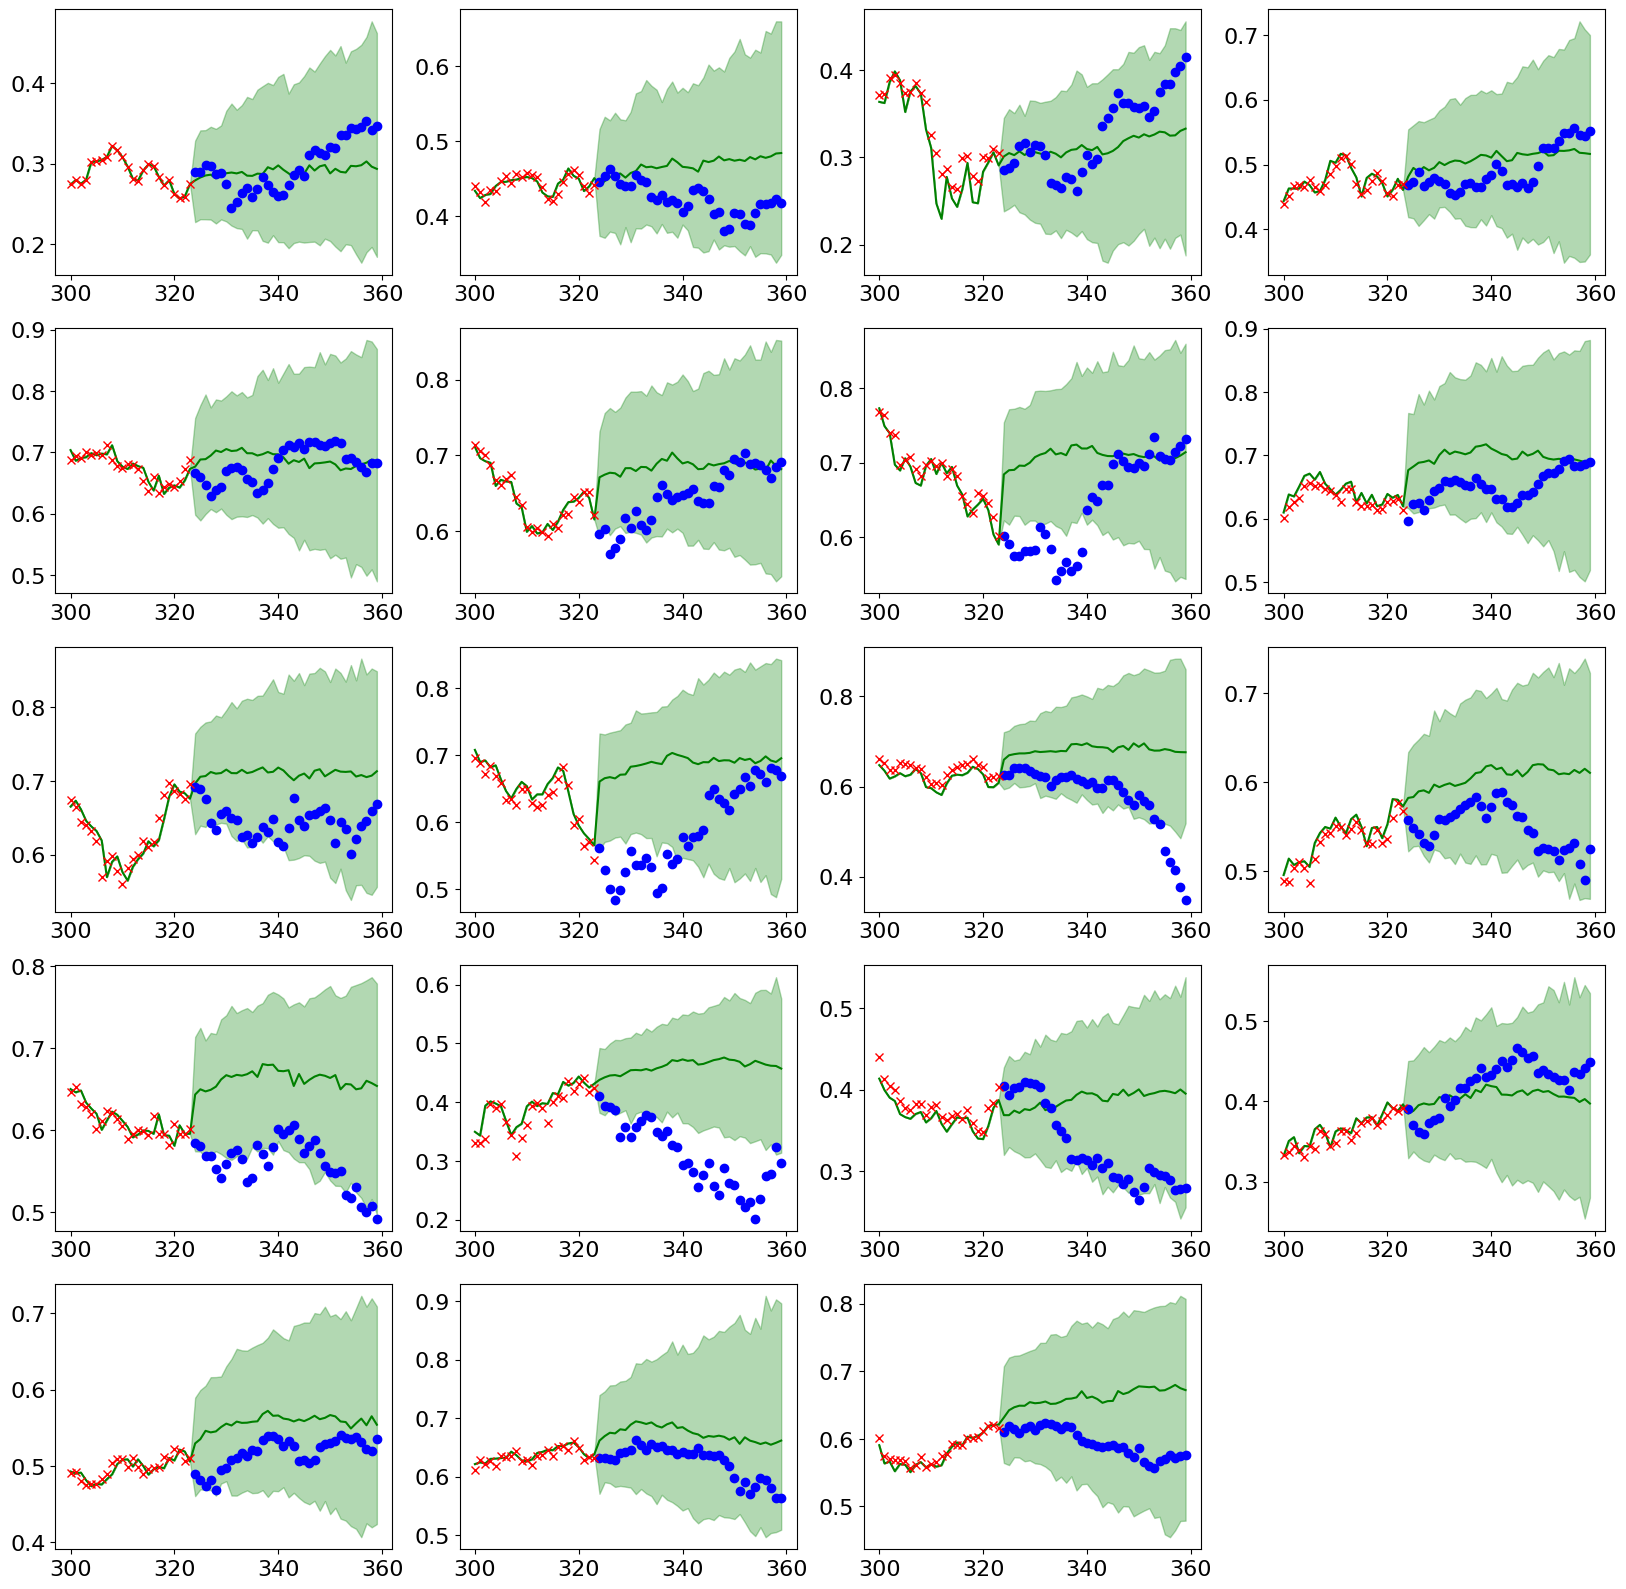

In [4]:
show_stock_forecast("fixed",0,20,)

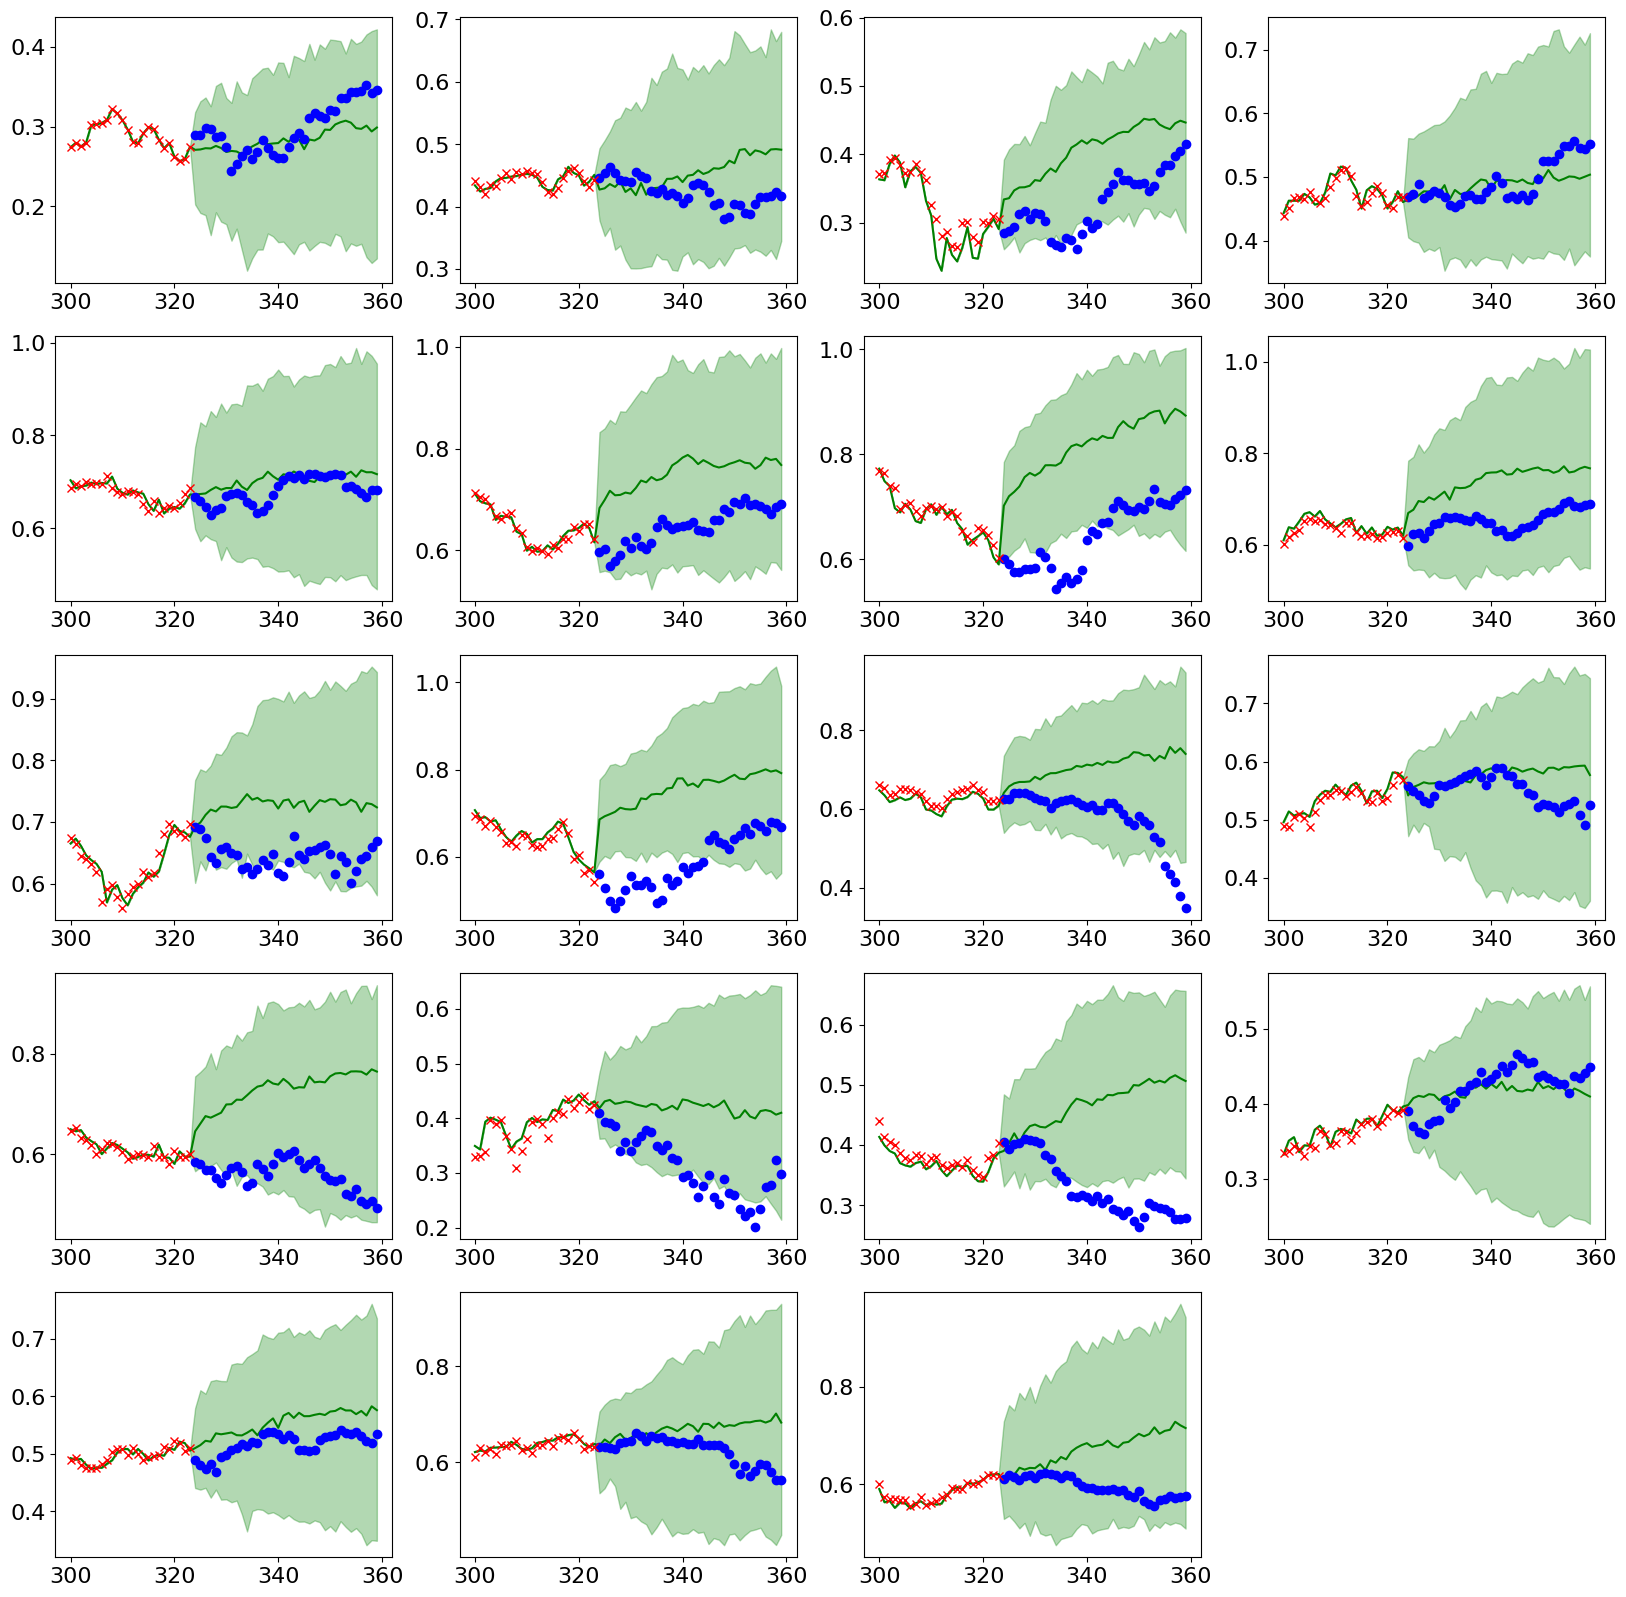

In [11]:
show_stock_forecast("forecast5",0,20)

In [17]:
def get_forecast_mask(observed_mask:torch.Tensor):
    """Mask observed values as missing ones with a weighted random strategy."""
    num_time_steps = observed_mask.shape[2]
    EXP_BASE=1.0/num_time_steps
    MASK_RATIO=0.10
    time_weights = torch.logspace(base=EXP_BASE,start=1,end=0,steps=num_time_steps).to(("cuda:0")) # Increasing weights from 0 to 1
    cond_mask=observed_mask.clone()
    
    for i in range(len(cond_mask)):
        mask=torch.rand_like(observed_mask[i])*time_weights
        k=   int(MASK_RATIO*observed_mask[i].sum().item())
        mask=mask.reshape(-1)
        mask[mask.topk(k).indices]=-1
        mask=mask>0
        cond_mask[i]=mask.reshape(cond_mask[i].shape).float()
    return cond_mask

In [18]:
a=torch.ones((1,4,360),device=("cuda"))

In [19]:
b=get_forecast_mask(a).cpu()[0]

<AxesSubplot: >

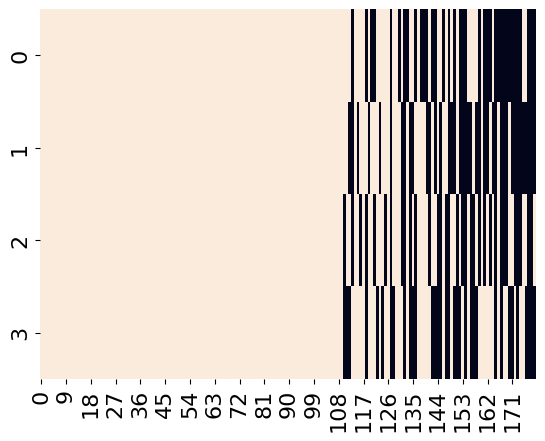

In [21]:
import seaborn as sns
sns.heatmap(b[:,180:],cbar=False)

In [72]:
def get_forecast_mask_ver2(observed_mask:torch.Tensor):
    """Mask observed values as missing ones with a weighted random strategy."""
    """linear timespan weight array"""
    num_attr=observed_mask.shape[1]
    num_time = observed_mask.shape[2]
    MISS_RATIO=0.10
    FADE_RATIO=0.04
    len_ones=int(num_time*(1-MISS_RATIO-FADE_RATIO))
    len_zeros=int(num_time*(MISS_RATIO-FADE_RATIO))
    len_fade=num_time-len_ones-len_zeros
    ONES=torch.ones((num_attr,len_ones),device=("cuda"))
    ZEROS=torch.zeros((num_attr,len_zeros),device=("cuda"))

    weights=torch.linspace(start=0.01,end=1,steps=len_fade,device=("cuda"))

    cond_mask=observed_mask.clone()
    
    for i in range(len(cond_mask)):
        mask=torch.rand((num_attr,len_fade),device=("cuda"))
        size=num_attr*len_fade
        mask*=weights
        _mask_ratio=np.random.rand()
        k=   int(_mask_ratio*size)
        mask=mask.reshape(-1)
        mask[mask.topk(k).indices]=-1
        mask=mask>0
        mask=mask.reshape((num_attr,len_fade))
        print(ONES.shape,mask.shape,ZEROS.shape)
        _mask=torch.cat( [ONES,mask,ZEROS],dim=1)
        cond_mask[i]=_mask.float()
    return cond_mask


In [41]:
a=torch.ones((1,4,360),device=("cuda"))

torch.Size([4, 309]) torch.Size([4, 30]) torch.Size([4, 21])


<AxesSubplot: >

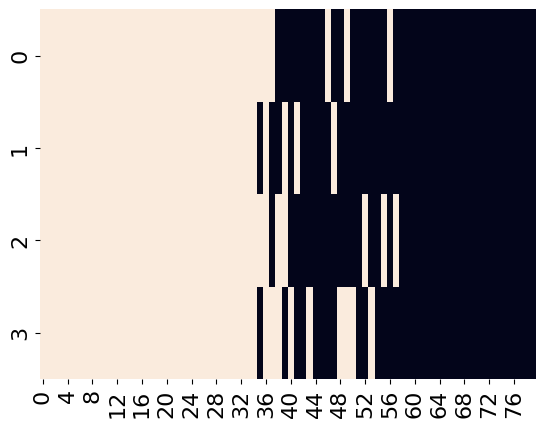

In [73]:
b=get_forecast_mask_ver2(a).cpu()[0]
sns.heatmap(b[:,280:],cbar=False)

In [74]:
num_attr=4
num_time =360
MISS_RATIO=0.10
FADE_RATIO=0.04
len_ones=int(num_time*(1-MISS_RATIO-FADE_RATIO))
len_zeros=int(num_time*(MISS_RATIO-FADE_RATIO))
len_fade=num_time-len_ones-len_zeros
ONES=torch.ones((num_attr,len_ones),device=("cuda"))
ZEROS=torch.zeros((num_attr,len_zeros),device=("cuda"))
SLOPE=1.0/(num_time*len_fade)
weights=torch.linspace(start=0.01,end=1,steps=len_fade,device=("cuda"))
def get_forecast_mask_ver2(observed_mask:torch.Tensor):
    """Mask observed values as missing ones with a weighted random strategy."""
    """linear timespan weight array"""


    cond_mask=observed_mask.clone()
    
    for i in range(len(cond_mask)):
        mask=torch.rand((num_attr,len_fade),device=("cuda"))
        mask*=weights
        mask=torch.floor(mask+0.50)
        k=int(np.random.rand()*num_attr*len_fade) #or change ratio with a fixed value like MISS_RATIO
        mask=mask.reshape(-1)
        mask[mask.topk(k).indices]=-1
        mask=mask>0
        mask=mask.reshape((num_attr,len_fade))
        _mask=torch.cat( [ONES,mask,ZEROS],dim=1)
        cond_mask[i]=_mask.float()
    return cond_mask

<AxesSubplot: >

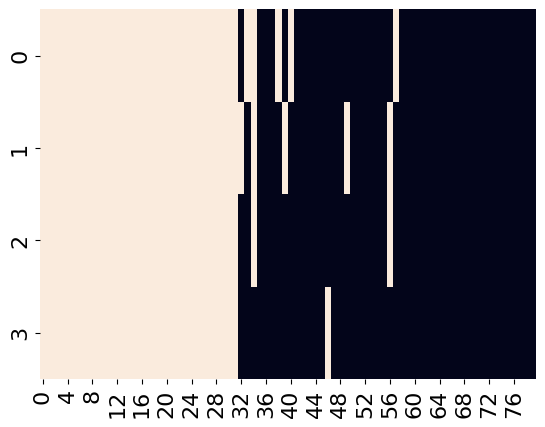

In [79]:
b=get_forecast_mask_ver2(a).cpu()[0]
sns.heatmap(b[:,280:],cbar=False)